In [1]:
import sys

sys.path.append('/Users/brianlenardo/Research/nEXO/sensitivity/modules')

In [2]:
import pandas as pd
import histlite as hl
import numpy as np
from matplotlib import pyplot as plt

In [3]:
import nEXOFitWorkspace
import nEXOFitModel
import nEXOFitLikelihood

In [4]:
workspace = nEXOFitWorkspace.nEXOFitWorkspace()

In [5]:
workspace.LoadInputDataframe('../tables/Summary_D-005_v22_2018-11-12_02.h5')


Loading input data from materials database spreadsheet....

Loaded dataframe with 130 components.
Contains the following quantities of interest:
	PDFName
	Component
	Isotope
	MC ID
	Histogram
	HistogramAxisNames
	Total Mass or Area
	Halflife
	SpecActiv
	SpecActivErr
	RawActiv
	RawActivErr
	Activity ID
	Expected Counts
	Expected Counts Err
	Expected Counts UL
	TotalHitEff_N
	TotalHitEff_K
	Group

Fit variables:
	['SS/MS', 'Energy (keV)', 'Standoff (mm)']


In [6]:
workspace.CreateGroupedPDFs()


Creating grouped PDFs....
	Group:     	Expected Counts:
	Far        	        4882.22
	VesselU-238 	       19053.03
	VesselTh-232 	        2169.26
	Off        	      754245.90
	InternalU-238 	       39901.84
	InternalTh-232 	        7703.98
	FullTpcCo-60 	           0.45
	FullTpcK-40 	    31965349.11
	Rn-222     	        9107.27
	FullLXeBb2n 	    27949377.02
	FullLXeBb0n 	           0.00
	Xe-137     	          46.52
	Total Sum  	    59992708.48


In [7]:
# Check and make sure any component is normalized to one total count.
h_intu238 = workspace.df_group_pdfs['Histogram'].loc[ \
                      workspace.df_group_pdfs['Group']=='InternalU-238' ].values[0]
print(h_intu238)

Hist(2 bins in [0,2], 280 bins in [700.0,3500.0], 25 bins in [0.0,650.0]) with sum 0.9999999999999999, 7709 empty bins, and 0 non-finite values


In [8]:
model = nEXOFitModel.nEXOFitModel()

In [9]:
model.AddHistogramsFromDataframe( workspace.df_group_pdfs )

In [10]:
initial_model = model.GenerateModelDistribution()

In [11]:
fake_data = model.GenerateDataset()

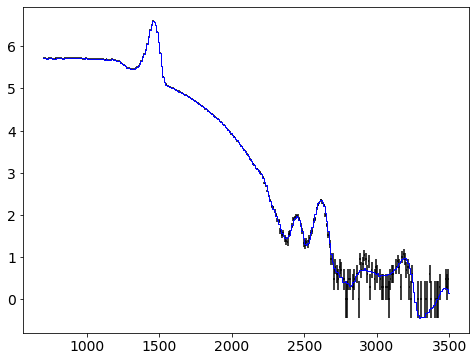

In [12]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots (1, 1, figsize=(8, 6))

hl.plot1d(ax, initial_model.project([1]).log10(),color=(0.,0.,1.),linewidth=1)
hl.plot1d(ax, fake_data.project([1]).log10(),color=(0.,0.,0.), crosses=True)

In [13]:
likelihood = nEXOFitLikelihood.nEXOFitLikelihood()

In [14]:
likelihood.AddPDFDataframeToModel(workspace.df_group_pdfs)
initial_guess = np.ones(len(likelihood.variable_list))
for i in range(len(likelihood.variable_list)):
    initial_guess[i] = (likelihood.variable_list[i]['Value'])
print(initial_guess)

[1.90530261e+04 2.16925971e+03 3.99018437e+04 7.70398482e+03
 4.47709845e-01 3.19653491e+07 9.10726717e+03 2.79493770e+07
 1.00000000e-04 4.65166535e+01]


In [15]:
likelihood.AddDataset( likelihood.model_obj.GenerateDataset() )

In [16]:
variable_values = np.ones(len(likelihood.variable_list))
for i in range(0,len(variable_values)):
    variable_values[i] = likelihood.variable_list[i]['Value']

In [17]:
print(likelihood.variable_list[-2]['Name'])

Num_FullLXeBb0n


In [18]:
from iminuit import Minuit

In [19]:
def NegLogLikelihood(parameter_values):
    return likelihood.ComputeNegLogLikelihood(parameter_values)

In [20]:
initial_values = initial_guess
variable_names = tuple(var['Name'] for var in likelihood.initial_values)
error_tuple = tuple( 0.02*var['Value'] for var in likelihood.initial_values )
par_fix_list = [ False for i in range(len(likelihood.initial_values)) ]
#par_fix_list[-2] = True
par_fix_tuple = tuple( x for x in par_fix_list )


m = Minuit.from_array_func( NegLogLikelihood, \
                            initial_values, \
                            error=error_tuple, \
                            fix=par_fix_tuple, \
                            name=variable_names, \
                            errordef = 0.5 )
m.get_param_states()

--------------------------------------------------------------------------------------------------------
|   | Name               |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
--------------------------------------------------------------------------------------------------------
| 0 | Num_VesselU-238    |  1.91E4   |  0.04E4   |            |            |         |         |       |
| 1 | Num_VesselTh-232   |   2170    |    40     |            |            |         |         |       |
| 2 | Num_InternalU-238  |  0.399E5  |  0.008E5  |            |            |         |         |       |
| 3 | Num_InternalTh-232 |  0.770E4  |  0.015E4  |            |            |         |         |       |
| 4 | Num_FullTpcCo-60   |   0.448   |   0.009   |            |            |         |         |       |
| 5 | Num_FullTpcK-40    |  0.320E8  |  0.006E8  |            |            |         |         |       |
| 6 | Num_Rn-222         |  0.911E4  |  0.018E4  |            |            |         |         |       |
| 7 | Num_FullLXeBb2n    |  2.79E7   |  0.06E7   |            |            |         |         |       |
| 8 | Num_FullLXeBb0n    | 1.000E-4  | 0.020E-4  |            |            |         |         |       |
| 9 | Num_Xe-137         |   46.5    |    0.9    |            |            |         |         |       |
--------------------------------------------------------------------------------------------------------

In [21]:
m.migrad()

------------------------------------------------------------------
| FCN = -4.445E+04              |     Ncalls=451 (451 total)     |
| EDM = 2.23E-05 (Goal: 5E-06)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------
|   | Name               |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
--------------------------------------------------------------------------------------------------------
| 0 | Num_VesselU-238    |   1.5E4   |   0.4E4   |            |            |         |         |       |
| 1 | Num_VesselTh-232   |  0.36E4   |  0.05E4   |            |            |         |         |       |
| 2 | Num_InternalU-238  |  0.42E5   |  0.04E5   |            |            |         |         |       |
| 3 | Num_InternalTh-232 |  0.64E4   |  0.06E4   |            |            |         |         |       |
| 4 | Num_FullTpcCo-60   |  0.32E4   |  0.19E4   |            |            |         |         |       |
| 5 | Num_FullTpcK-40    |  0.320E8  |  0.000E8  |            |            |         |         |       |
| 6 | Num_Rn-222         |  0.96E4   |  0.15E4   |            |            |         |         |       |
| 7 | Num_FullLXeBb2n    |  2.795E7  |  0.001E7  |            |            |         |         |       |
| 8 | Num_FullLXeBb0n    |    14     |     8     |            |            |         |         |       |
| 9 | Num_Xe-137         |    50     |    23     |            |            |         |         |       |
--------------------------------------------------------------------------------------------------------

In [22]:
nll_best = m.fval

par_values_best = np.array([value for key,value in m.values.items()])

print(nll_best)
print(par_values_best)

-44447.79087972641
[1.54778652e+04 3.55585273e+03 4.23392895e+04 6.35240370e+03
 3.23806977e+03 3.19570133e+07 9.62483478e+03 2.79543446e+07
 1.35280710e+01 5.01606210e+01]


In [56]:
num_datasets = 20
num_hypotheses = 15
xvals = np.linspace(0,28,15)
lambdas = np.zeros((num_datasets,num_hypotheses))
converged = np.ones(num_datasets,dtype=bool)


[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]


In [57]:


for j in range(0,num_datasets):
    print('Running dataset {}'.format(j))
    likelihood.model_obj.UpdateVariables(initial_guess)
    likelihood.model_obj.GenerateModelDistribution()
    likelihood.AddDataset( likelihood.model_obj.GenerateDataset() )

    initial_values = np.copy(initial_guess)
    variable_names = tuple(var['Name'] for var in likelihood.initial_values)
    error_tuple = tuple( 0.02*var['Value'] for var in likelihood.initial_values )
    par_fix_list = [ False for i in range(len(likelihood.initial_values)) ]
    #par_fix_list[-2] = True
    par_fix_tuple = tuple( x for x in par_fix_list )


    m = Minuit.from_array_func( NegLogLikelihood, \
                            initial_values, \
                            error=error_tuple, \
                            fix=par_fix_tuple, \
                            name=variable_names, \
                            errordef = 0.5 )
    m.migrad()
    nll_best = m.fval
    if not m.get_fmin()['is_valid']:
        converged[j] = False
    
    
    for i in (range(0,num_hypotheses)):
        initial_values = np.copy(initial_guess)
        initial_values[-2] = float(i)*2.+0.0001
        variable_names = tuple(var['Name'] for var in likelihood.initial_values)
        error_tuple = tuple( 0.02*var['Value'] for var in likelihood.initial_values )
        par_fix_list = [ False for i in range(len(likelihood.initial_values)) ]
        par_fix_list[-2] = True
        par_fix_tuple = tuple( x for x in par_fix_list )
    

        m = Minuit.from_array_func( NegLogLikelihood, \
                            initial_values, \
                            error=error_tuple, \
                            fix=par_fix_tuple, \
                            name=variable_names, \
                            errordef = 0.5 )
        m.migrad()
        lambdas[j,i] = 2*(m.fval - nll_best)
        if not m.get_fmin()['is_valid']:
            converged[j] = False

Running dataset 0
[1.90530261e+04 2.16925971e+03 3.99018437e+04 7.70398482e+03
 4.47709845e-01 3.19653491e+07 9.10726717e+03 2.79493770e+07
 1.00000000e-04 4.65166535e+01]
Running dataset 1
[1.90530261e+04 2.16925971e+03 3.99018437e+04 7.70398482e+03
 4.47709845e-01 3.19653491e+07 9.10726717e+03 2.79493770e+07
 1.00000000e-04 4.65166535e+01]
Running dataset 2
[1.90530261e+04 2.16925971e+03 3.99018437e+04 7.70398482e+03
 4.47709845e-01 3.19653491e+07 9.10726717e+03 2.79493770e+07
 1.00000000e-04 4.65166535e+01]
Running dataset 3
[1.90530261e+04 2.16925971e+03 3.99018437e+04 7.70398482e+03
 4.47709845e-01 3.19653491e+07 9.10726717e+03 2.79493770e+07
 1.00000000e-04 4.65166535e+01]
Running dataset 4
[1.90530261e+04 2.16925971e+03 3.99018437e+04 7.70398482e+03
 4.47709845e-01 3.19653491e+07 9.10726717e+03 2.79493770e+07
 1.00000000e-04 4.65166535e+01]
Running dataset 5
[1.90530261e+04 2.16925971e+03 3.99018437e+04 7.70398482e+03
 4.47709845e-01 3.19653491e+07 9.10726717e+03 2.79493770e+07


Text(0.5, 0, 'Number of 0nuBB counts')

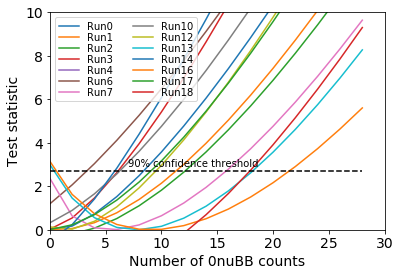

In [67]:
for i in range(0,20):
    if converged[i]:
        plt.plot(xvals,lambdas[i],'-',label='Run{}'.format(i))
plt.plot(xvals,np.ones(len(xvals))*2.706,'--k')
plt.text(7.,2.9,'90% confidence threshold',fontsize=10)
plt.axis([0.,30.,0.,10.])
plt.legend(loc='upper left',fontsize=10,ncol=2,labelspacing=0.1)
plt.ylabel('Test statistic')
plt.xlabel('Number of 0nuBB counts')

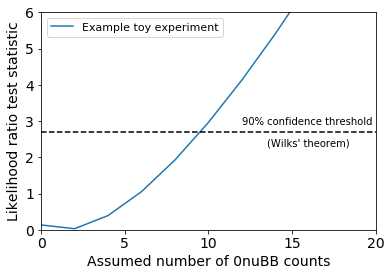

In [80]:
plt.plot(xvals,lambdas[12],'-',label='Example toy experiment')
plt.plot(xvals,np.ones(len(xvals))*2.706,'--k')
plt.text(12.,2.9,'90% confidence threshold',fontsize=10)
plt.text(13.5,2.3,'(Wilks\' theorem)',fontsize=10)
plt.axis([0.,20.,0.,6.])
plt.legend(loc='upper left',fontsize=11,ncol=2,labelspacing=0.1)
plt.ylabel('Likelihood ratio test statistic')
plt.xlabel('Assumed number of 0nuBB counts')
plt.savefig('example_toy_experiment_test_statistic.png',dpi=400,bbox_inches='tight')

In [81]:
crossings = np.zeros(20)

for i in range(0,20):
    if converged[i]:
        p = np.polyfit(xvals,lambdas[i],2.)
    crossings[i] = (-p[1] + np.sqrt( p[1]**2 - 4*(p[0])*(p[2]-2.706) ))/(2*p[0])




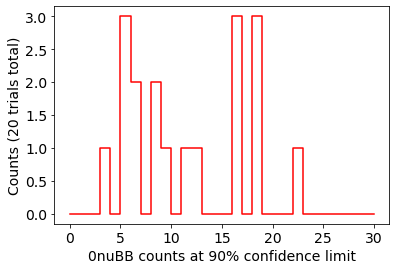

In [98]:
fig,ax = plt.subplots(1,1)
hteststats = hl.hist(crossings[crossings>0.],bins=np.linspace(0,30,31))
hl.plot1d(ax,hteststats,color='r')
ax.set_ylabel('Counts (20 trials total)')
ax.set_xlabel('0nuBB counts at 90% confidence limit')
plt.savefig('example_sensitivity_distribution.png',dpi=400,bbox_inches='tight')

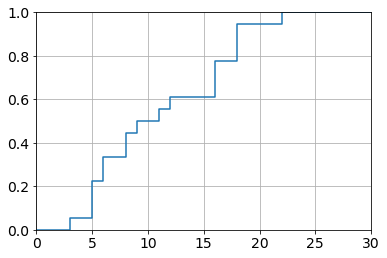

In [99]:
hcdf = hl.Hist(hteststats.bins,np.cumsum(hteststats.values)/np.sum(hteststats.values))
hl.plot1d(hcdf)
plt.axis([0.,30.,0.,1.])
plt.grid()